In [1]:
%pip install -U langchain_community langchain-openai langchain langgraph bs4

  Using cached langchain_community-0.3.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached langchain_openai-0.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain-0.3.3-py3-none-any.whl.metadata (7.1 kB)
  Using cached langgraph-0.2.35-py3-none-any.whl.metadata (13 kB)
  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached langchain_core-0.3.10-py3-none-any.whl.metadata (6.3 kB)
  Using cached langsmith-0.1.134-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pydantic_settings-2.5.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tenacity-8.5.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached openai-1.51.2-py3-none-any.whl.metadata (24 kB)
  Using cached langchain_text_splitters-0.3.0-py3-none-any.whl.metada

In [60]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
_set_env("AIML_API_KEY")

In [5]:
%pip install crawl4ai
%pip install nest-asyncio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import asyncio
import nest_asyncio
from crawl4ai import AsyncWebCrawler
from crawl4ai.extraction_strategy import JsonCssExtractionStrategy, LLMExtractionStrategy
import json
import time
from pydantic import BaseModel, Field

nest_asyncio.apply()

In [17]:
async def simple_crawl(url):
    async with AsyncWebCrawler(verbose=True) as crawler:
        result = await crawler.arun(url=url)
        return result.markdown
result = asyncio.run(simple_crawl("https://langchain-ai.github.io/langgraph/how-tos/branching/"))
result

[LOG] 🌤️  Warming up the AsyncWebCrawler
[LOG] 🌞 AsyncWebCrawler is ready to crawl
[LOG] 🕸️ Crawling https://langchain-ai.github.io/langgraph/how-tos/branching/ using AsyncPlaywrightCrawlerStrategy...
[LOG] ✅ Crawled https://langchain-ai.github.io/langgraph/how-tos/branching/ successfully!
[LOG] 🚀 Crawling done for https://langchain-ai.github.io/langgraph/how-tos/branching/, success: True, time taken: 0.91 seconds
[LOG] 🚀 Content extracted for https://langchain-ai.github.io/langgraph/how-tos/branching/, success: True, time taken: 0.09 seconds
[LOG] 🔥 Extracting semantic blocks for https://langchain-ai.github.io/langgraph/how-tos/branching/, Strategy: AsyncWebCrawler
[LOG] 🚀 Extraction done for https://langchain-ai.github.io/langgraph/how-tos/branching/, time taken: 0.09 seconds.


'Skip to content\n\n![\\\\"logo\\\\"](\\\\"https://langchain-\nai.github.io/langgraph/static/wordmark_dark.svg\\\\"/)\n![\\\\"logo\\\\"](\\\\"https://langchain-\nai.github.io/langgraph/static/wordmark_light.svg\\\\"/)\n\nCreate branches for parallel execution\n\nInitializing search\n\nGitHub\n\n  * Home \n  * Tutorials \n  * How-to Guides \n  * Conceptual Guides \n  * Reference \n  * Cloud (beta) \n\n![\\\\"logo\\\\"](\\\\"https://langchain-\nai.github.io/langgraph/static/wordmark_dark.svg\\\\"/)\n![\\\\"logo\\\\"](\\\\"https://langchain-\nai.github.io/langgraph/static/wordmark_light.svg\\\\"/)\n\nGitHub\n\n  * Home \n  * Tutorials \n  * How-to Guides \n\nHow-to Guides\n\n    * Controllability  Controllability \n      * Create branches for parallel execution  Create branches for parallel execution  Table of contents \n        * Setup \n        * Parallel node fan-out and fan-in \n        * Parallel node fan-out and fan-in with extra steps \n        * Conditional Branching \n        * S

In [15]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# Langgraph how tos docs
url = "https://langchain-ai.github.io/langgraph/how-tos/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs_how_to = loader.load()

# Langgraph tutorial docs
url = "https://langchain-ai.github.io/langgraph/tutorials/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs_tutorial = loader.load()

# # Sort the list based on the URLs and get the text
# d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
# d_reversed = list(reversed(d_sorted))
# concatenated_content = "\n\n\n --- \n\n\n".join(
#     [doc.page_content for doc in d_reversed]
# )

In [20]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LangGraph. \n 
    Here is a full set of LangGraph how tos and tutorials documentation:  \n ------- \n  {context} \n ------- \n Answer the user question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


expt_llm = "gpt-4o"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain_oai = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a parallel branch in LangGraph?"
solution = code_gen_chain_oai.invoke(
    {"context": result, "messages": [("user", question)]}
)
solution

code(prefix='To build a parallel branch in LangGraph, you can use the fan-out and fan-in mechanism. This involves creating nodes that branch out from a single node and then converge back into another node. The process is facilitated by the StateGraph class, which allows you to define nodes and edges, and specify how data should be aggregated using reducers. In this example, we create a graph where Node A fans out to Nodes B and C, and then both converge into Node D. The reducer function is used to accumulate values from each node into a list.', imports='import operator\nfrom typing import Annotated, Any\nfrom typing_extensions import TypedDict\nfrom langgraph.graph import StateGraph, START, END', code='class State(TypedDict):\n    # The operator.add reducer fn makes this append-only\n    aggregate: Annotated[list, operator.add]\n\nclass ReturnNodeValue:\n    def __init__(self, node_secret: str):\n        self._value = node_secret\n\n    def __call__(self, state: State) -> Any:\n       

In [94]:
# Initialize the LLM
llm = ChatOpenAI(temperature=1, model="o1-mini", base_url="https://api.aimlapi.com/v1", api_key=os.environ["AIML_API_KEY"])

# Create a simple prompt template
prompt = ChatPromptTemplate.from_messages([
    ("human", "{input}")
])

# Create a simple chain
chain = prompt | llm

# Test the chain
response = chain.invoke({"input": "What are the 5 most common questions users ask about LangGraph? If you don't know the answer, just say so."})

print(response.content)

In [95]:
response.content

"I'm sorry, but I don't have specific information about LangGraph. It's possible that it's a tool or platform that emerged after my last update in October 2023, or it might be a specialized tool not widely documented. If you can provide more details or context about LangGraph, I'd be happy to try to help further!"

In [22]:
# Test
question = "How do I build a RAG chain in LangGraph?"
solution = code_gen_chain_oai.invoke(
    {"context": result, "messages": [("user", question)]}
)
solution

code(prefix='To build a RAG (Retrieval-Augmented Generation) chain in LangGraph, you need to create a graph that retrieves information from a knowledge base and then uses that information to generate a response. This involves setting up nodes for retrieval and generation, and connecting them with edges to form a chain. The retrieval node will query the knowledge base, and the generation node will use the retrieved information to produce a response. Below is an example of how you can set up such a chain in LangGraph.', imports='from langgraph.graph import StateGraph, START, END\nfrom typing import Annotated, Any\nfrom typing_extensions import TypedDict\nimport operator', code='class State(TypedDict):\n    # The operator.add reducer fn makes this append-only\n    aggregate: Annotated[list, operator.add]\n    retrieved_info: str\n\nclass RetrieveNode:\n    def __init__(self, query: str):\n        self.query = query\n\n    def __call__(self, state: State) -> Any:\n        # Simulate retrie

In [23]:
# o1 Reasoning
# take 5 random docs and ask complex questions that a user might ask
# generate code for the question using these docs

prefix='To build a RAG (Retrieval-Augmented Generation) chain in LangGraph, you need to create a graph that retrieves information from a knowledge base and then uses that information to generate a response. This involves setting up nodes for retrieval and generation, and connecting them with edges to form a chain. The retrieval node will query the knowledge base, and the generation node will use the retrieved information to produce a response. Below is an example of how you can set up such a chain in LangGraph.' imports='from langgraph.graph import StateGraph, START, END\nfrom typing import Annotated, Any\nfrom typing_extensions import TypedDict\nimport operator' code='class State(TypedDict):\n    # The operator.add reducer fn makes this append-only\n    aggregate: Annotated[list, operator.add]\n    retrieved_info: str\n\nclass RetrieveNode:\n    def __init__(self, query: str):\n        self.query = query\n\n    def __call__(self, state: State) -> Any:\n        # Simulate retrieval fro

## Graph

In [24]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

In [25]:
code_gen_chain = code_gen_chain_oai

In [26]:
### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": result, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": result, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [27]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

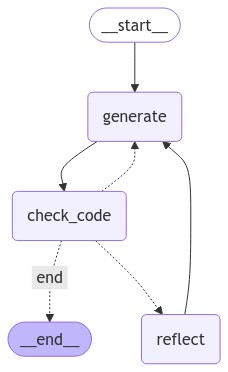

In [28]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [31]:
question = "How do I build a parallel branch in LangGraph? and how do I use it to build a RAG chain?"
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})
solution

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---


{'error': 'yes',
 'messages': [('user',
   'How do I build a parallel branch in LangGraph? and how do I use it to build a RAG chain?'),
  ('assistant',
   'To build a parallel branch in LangGraph, you can use the fan-out and fan-in mechanism. This allows you to execute multiple nodes in parallel and then combine their results. Here\'s a basic example of how to set up a parallel branch in LangGraph. For building a RAG (Retrieval-Augmented Generation) chain, you would typically have nodes that handle retrieval and generation separately, and you can use parallel branches to handle multiple retrievals or generations simultaneously. Below is a simple example of setting up a parallel branch in LangGraph. \n Imports: import operator\nfrom typing import Annotated, Any\nfrom typing_extensions import TypedDict\nfrom langgraph.graph import StateGraph, START, END \n Code: class State(TypedDict):\n    # The operator.add reducer fn makes this append-only\n    aggregate: Annotated[list, operator.add]

In [52]:
import subprocess
import pytest

def write_generated_code(code):
    # Write the generated code into the placeholder file
    with open("generated/generated_code.py", "w") as file:
        file.write(code)

def run_generated_code():
    # Execute the generated code in a separate process
    result = subprocess.run(["python", "generated/generated_code.py"], capture_output=True, text=True)
    print("Execution Output:", result.stdout)
    if result.stderr:
        print("Execution Error:", result.stderr)
    return result.stdout

def run_tests():
    # Run tests programmatically with pytest and capture output
    import io
    import sys

    # Redirect stdout and stderr to a buffer
    captured_output = io.StringIO()
    sys.stdout = captured_output
    sys.stderr = captured_output

    # Run pytest
    result = pytest.main(["-v", "generated/test_generated_code.py"])

    # Restore stdout and stderr
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__

    # Get the captured output (including stack traces)
    output = captured_output.getvalue()

    print("Test Output:")
    print(output)
    print(f"Test result code: {result}")

    return result, output

# Generated Python code to be written to generated_code.py
generated_code = """
def function():
    return "expected output"

if __name__ == "__main__":
    print(function())
"""

# Write the generated code to file
write_generated_code(generated_code)

# Run the generated code
print("Running generated code...")
output = run_generated_code()

# Run the tests
print("Running tests...")
result, test_output = run_tests()

Running generated code...
Execution Output: expected output

Running tests...
Test Output:
============================= test session starts ==============================
platform linux -- Python 3.11.10, pytest-8.3.3, pluggy-1.5.0 -- /home/kenji/mambaforge/envs/codegen/bin/python
cachedir: .pytest_cache
rootdir: /home/kenji/hack-projects/IdeaGenerator
plugins: anyio-4.6.0
collecting ... collected 1 item

generated/test_generated_code.py::test_example FAILED                    [100%]

=================================== FAILURES ===================================
_________________________________ test_example _________________________________

    def test_example():
        # Basic example test to check if code runs without error
>       assert generated_code2.function() == "expected output"
E       AssertionError: assert 'expected output' == 'expected outp u t'
E         
E         - expected outp u t
E         ?              - -
E         + expected output

generated/test_generate

In [53]:
print(f"Test result: {result}, {test_output}")

In [54]:
result

<ExitCode.TESTS_FAILED: 1>

In [59]:
test_output

'\x1b============================= test session starts ==============================\x1b\nplatform linux -- Python 3.11.10, pytest-8.3.3, pluggy-1.5.0 -- /home/kenji/mambaforge/envs/codegen/bin/python\ncachedir: .pytest_cache\nrootdir: /home/kenji/hack-projects/IdeaGenerator\nplugins: anyio-4.6.0\n\x1bcollecting ... \x1bcollected 1 item\n\ngenerated/test_generated_code.py::test_example \x1bFAILED\x1b\x1b                    [100%]\x1b\n\n=================================== FAILURES ===================================\n\x1b\x1b_________________________________ test_example _________________________________\x1b\n\n    \x1b\x1bdef\x1b \x1btest_example\x1b():\x1b\x1b\n        \x1b# Basic example test to check if code runs without error\x1b\x1b\x1b\n>       \x1bassert\x1b generated_code2.function() == \x1b"\x1b\x1bexpected output\x1b\x1b"\x1b\x1b\x1b\n\x1b\x1bE       AssertionError: assert \'expected output\' == \'expected outp u t\'\x1b\n\x1b\x1bE         \x1b\n\x1b\x1bE         - expected